# Data Analysis in Geoscience Remote Sensing Projects: Exercises 
## Solutions to tasks: Regression analysis and sensitivity estimation

Hendrik Andersen | contact: hendrik.andersen@kit.edu

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr, linregress

# Read in data as pandas dataframe
df = pd.read_csv('Fremont.csv', index_col='Date', parse_dates=True)
df = df.rename(columns={"Fremont Bridge Total": "total", 
                        "Fremont Bridge East Sidewalk": "east",
                        "Fremont Bridge West Sidewalk": "west"}) 

X = df['east'].resample('m').mean()
y = df['west'].resample('m').mean()
z = df['total'].resample('m').mean()

__Tasks:__

1. Compute the RSS (residual sum of squares) and RSE (residual standard error) for the regression model
2. Create a residual plot to analyse the residuals. Are there any issues with the data?
3. Interpret the p-value: Can we reject the 0-hypothesis that there is no relationship between X and y? 
4. Compute the R$^2$ statistic: How much (%) of the variation in y is explained by X?

Residual sum of squares is : 20491.674376268587
Residual standard error  is : 13.177945872783246


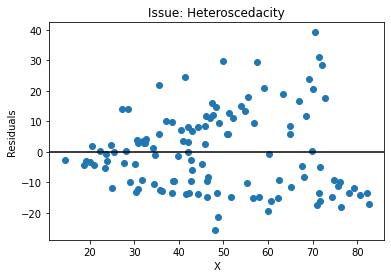

In [2]:
from sklearn.linear_model import LinearRegression
import math

regr = LinearRegression()
X_ = np.expand_dims(X, axis = 1)
regr.fit(X_,y)
y_pred = regr.predict(X_)

RSS = np.sum(np.square(y_pred - y))
RSE = math.sqrt(RSS / (len(y) - 2))


print('Residual sum of squares is : '+ str(RSS))
print('Residual standard error  is : '+ str(RSE))
residuals = (y-y_pred)
plt.scatter(X,residuals)
plt.ylabel('Residuals')
plt.xlabel('X')
plt.axhline(0, c='k')
plt.title('Issue: Heteroscedacity') 
plt.show()

In [3]:
from scipy import stats
slope, intercept, rvalue, pvalue, stderr = stats.linregress(X,y)
print('Can we reject the 0-hypothesis that there is no relationship between X and y?: '  + str(pvalue < 0.05))

Can we reject the 0-hypothesis that there is no relationship between X and y?: True


In [4]:
from sklearn.metrics import r2_score
print('R2 statistic: %.2f' % r2_score(y, y_pred))
print('The regression explains 64% of the variability in y')

R2 statistic: 0.64
The regression explains 64% of the variability in y


__Tasks:__

5. Compute the correlations at different temporal resolutions (daily, weekly, monthly). Tip: Use resample() or groupby()
6. Compute a linear regression between east and west for the monthly means\
7. What is the prediction of the regression model for 'west', if 'east'=45 (daily resolution)
8. Describe in one sentence: How do you interpret the slope of a linear relationship?

In [5]:
X = df['west'].resample('d').mean()
y = df['east'].resample('d').mean()

r,p = pearsonr(X,y)
# The p-value is used to estimate the significance of the calculated correlation
print("Pearson correlation coefficient at the daily scale: ", r,"\n Significant at the 95% level : ",p < 0.05)

X = df['west'].resample('w').mean()
y = df['east'].resample('w').mean()

r,p = pearsonr(X,y)
# The p-value is used to estimate the significance of the calculated correlation
print("Pearson correlation coefficient at the weekly scale: ", r,"\n Significant at the 95% level : ",p < 0.05)

X = df['west'].resample('m').mean()
y = df['east'].resample('m').mean()

r,p = pearsonr(X,y)
# The p-value is used to estimate the significance of the calculated correlation
print("Pearson correlation coefficient at the monthly scale: ", r,"\n Significant at the 95% level : ",p < 0.05)

# 6.
slope, intercept, rvalue, pvalue, stderr = stats.linregress(X,y)

# 7.
print('The prediction for west if east is equal to 45 is: ', intercept + slope*45)

# 8.: (copied from script): The slope of the regression line is also called "regression coefficient" and can be understood as a sensitivity of y to a change in X 

Pearson correlation coefficient at the daily scale:  0.8524852924184673 
 Significant at the 95% level :  True
Pearson correlation coefficient at the weekly scale:  0.8106635826526547 
 Significant at the 95% level :  True
Pearson correlation coefficient at the monthly scale:  0.7982913615626022 
 Significant at the 95% level :  True
The prediction for west if east is equal to 45 is:  39.12452118493814


__Tasks:__

9. Compute a confidence interval for the two groups of data split with train_test_split. What is the reason for the differences in the range of the confidence interval?
10. Calculate a regression analysis for the outlier and high-leverage data and create a plot. Which of the issues (outlier/leverage) is more critical for sensitivity estimation?
11. Why is the line of the average slope_list approaching the true sensitivity?
12. What is the trend of CO2 at Mauna Loa for the considered time period (in PPM/decade)?

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1) # the random_state argument creates pseudo (reproducable) random data 

res_train = stats.linregress(X_train,y_train)
res_test = stats.linregress(X_test,y_test)

# here, we define a function that returns the confidence interval for the slope and the intercept 
def conf_int(X, model, p = 0.05):
    """
    This function calculates a confidence interval for a slope and intercept of a linear model.
    Only works when the model provided is a scipy.stats.linregress() model.
    Returns: confidence interval for a slope and intercept 
    """
    from scipy.stats import t
    ts = abs(t.ppf(p/2, len(X)-2))
    slope_ci = model.stderr*ts
    intercept_ci = model.intercept_stderr*ts
    return slope_ci, intercept_ci

slope_ci_train, intercept_ci_train = conf_int(X_train, res_train)
slope_ci_test, intercept_ci_test = conf_int(X_test, res_test)
print(f"slope (95%): {res_train.slope:.6f} +/- {slope_ci_train:.2f}")
print(f"slope (95%): {res_test.slope:.6f} +/- {slope_ci_test:.2f}")
print('Confidence range for the test data is much larger, as the sample size is smaller (model is less certain)')

slope (95%): 0.626931 +/- 0.10
slope (95%): 0.676660 +/- 0.22
Confidence range for the test data is much larger, as the sample size is smaller (model is less certain)


In [7]:
# create copies of the data sets
y_outlier = y.copy()
X_outlier = X.copy()
y_leverage = y.copy()
X_leverage = X.copy()

# Change the first data point in the X and y data sets to create an outlier and a high-leverage point 
y_outlier[0] = -5
X_outlier[0] = 0
y_leverage[0] = -5
X_leverage[0] = 2

lm_1 = stats.linregress(X,y)
lm_2 = stats.linregress(X_outlier,y_outlier)
lm_3 = stats.linregress(X_leverage,y_leverage)
print(lm_1.slope,lm_2.slope,lm_3.slope)
# Task 10
print('Outliers and high-leverage points should be removed, ideally. Especially high-leverage points typically influence estimated sensitivity')
# Task 11
print('The errors are drawn randomly. The more often this is done, the more likely these cancel out. This is called also often referred to regression to the mean.')

0.6324650656444454 0.6497140460852312 0.6504650536329337
Outliers and high-leverage points should be removed, ideally. Especially high-leverage points typically influence estimated sensitivity
The errors are drawn randomly. The more often this is done, the more likely these cancel out. This is called also often referred to regression to the mean.


The trend of the CO2 measurements at Mauna Loa is  [13.34]  [ppm/decade]


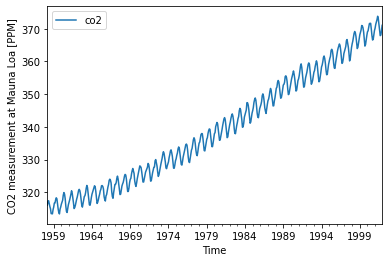

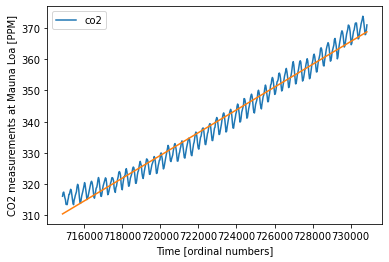

In [8]:
# Task 12

from sklearn.datasets import fetch_openml

# we are again using the co2 time series of Mauna Loa for this example. 

data = fetch_openml(data_id=41187, as_frame=True)
df = data.frame # convert as pandas data frame
df.index = pd.to_datetime(df[['year','month', 'day']]) # use the columns with temporal information to create time stamps and use them as index
df = df.drop(['year','month','day','weight','flag','station'], axis=1) # drop the columns that are not needed
df_resampled = df.resample('m').mean() # resample the data set to monthly means
df_resampled['co2'] = df_resampled['co2'].interpolate() # interpolate the missing values

df_resampled.plot(xlabel='Time',ylabel='CO2 measurement at Mauna Loa [PPM]')

# for the linear regression to work, we need to convert the time stamps to ordinal numbers
df_resampled.index = df_resampled.index.map(pd.Timestamp.toordinal)

# we are using the sklearn function LinearRegression()
model = LinearRegression()
# we can then fit the model on the nex index of the data frame (the ordinal numbers of the dates, and the co2 measurements)
model.fit(np.expand_dims(df_resampled.index.values,axis=1), df_resampled.co2.values)
# make a prediction for each date (ordinal number)
y_predicted = model.predict(np.expand_dims(df_resampled.index.values,axis=1))

ax = df_resampled.plot()
ax.plot(df_resampled.index, y_predicted)
ax.set_xlabel('Time [ordinal numbers]')
ax.set_ylabel('CO2 measurements at Mauna Loa [PPM]')

print('The trend of the CO2 measurements at Mauna Loa is ', np.round(model.coef_ * 3652.5,2), ' [ppm/decade]')

The linear regression is fit on the ordinal numbers (each day has a number), so that the resolution on the X axis is daily. As such, the default units of the linear regression slope is [ppm/day] to convert that to [ppm/decade], we need to multiply it by the average number of days per year (365.25) times the number of years contained in a decade (10). This is done in the code above: model.coef_ * 3652.5